# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_colwidth', None)
from tqdm.auto import tqdm
import pickle 
import random
import re
import math
import os
import json
import collections
from collections import Counter
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Define parameter

In [3]:
# The batch size is set to 64, meaning that 64 samples of data will be processed in one forward/backward pass of the network during training.
batch_size = 64

# The embedding size is set to 1280, meaning that each input sample will be represented by a vector of size 1280.
embedding_size = 1280

# Download and prepare dataset 

## Download image files

In [4]:
# Download image files and extract them
img_fol = '/train2017/'
if not os.path.exists(os.path.abspath('.') + img_fol):
  img_compressed = tf.keras.utils.get_file('train2017.zip', cache_subdir=os.path.abspath('.'),
                                                 origin='http://images.cocodataset.org/zips/train2017.zip', extract=True)
  PATH = os.path.dirname(img_compressed) + img_fol
  os.remove(img_compressed)
else:
  PATH = os.path.abspath('.') + img_fol

19336861798/19336861798 [==============================] - 1474s 0us/step


In [5]:
# Loads three sets of data in the JSON format into Python variables.

# Defines the path to the file containing the training set annotations in JSON format.
annotation_file = '/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/UIT_ViIC/uitviic_captions_train2017.json'

# Opens the file at the specified path in read mode and assigns its contents to the file handle ‘f’
# Parse the contents of the file handle ‘f’ and load it into a Python dictionary called ‘annotations’
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

annotation_validation_file = '/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/UIT_ViIC/uitviic_captions_val2017.json'

with open(annotation_validation_file, 'r') as f:
    annotations_validation = json.load(f)

annotation_test_file = '/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/UIT_ViIC/uitviic_captions_test2017.json'

with open(annotation_test_file, 'r') as f:
    annotations_test = json.load(f)

In [6]:
annotations['images'][:1]

[{'license': 2,
  'file_name': '000000535668.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000535668.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-19 18:06:56',
  'flickr_url': 'http://farm4.staticflickr.com/3061/2442277392_49eb08cb2f_z.jpg',
  'id': 535668}]

In [7]:
annotations['annotations'][:1]

[{'image_id': 157656,
  'caption': 'Người đàn ông đang đánh tennis ngoài sân.',
  'id': 4990}]

## Group all captions together having the same image ID.


In [8]:
# Group all captions together having the same image ID.

# ‘image_path_to_caption’, where the keys are the file paths to the images and the values are lists of captions for each image
img_path_to_caption = collections.defaultdict(list)

# Iterates through the ‘annotations['annotations']’ list, which contains information about the captions for each image. For each caption, 
# the code creates a string caption that starts with the special token ‘"<start>"’ and ends with the special token ‘"<end>"’.
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  img_path = PATH + '%012d.jpg' % (val['image_id'])
  img_path_to_caption[img_path].append(caption)

In [9]:
img_path_to_caption_val = collections.defaultdict(list)
for val in annotations_validation['annotations']:
  caption = f"<start> {val['caption']} <end>"
  img_path = PATH + '%012d.jpg' % (val['image_id'])
  img_path_to_caption_val[img_path].append(caption)

In [10]:
img_path_to_caption_test = collections.defaultdict(list)
for val in annotations_test['annotations']:
  caption = f"<start> {val['caption']} <end>"
  img_path = PATH + '%012d.jpg' % (val['image_id'])
  img_path_to_caption_test[img_path].append(caption)

## Convert to dataframe

In [11]:
df_train = (pd.DataFrame.from_dict(img_path_to_caption, orient='index').T.melt(var_name='image', value_name='caption')
            .dropna(subset=['caption'])) 

df_val = (pd.DataFrame.from_dict(img_path_to_caption_val, orient='index').T.melt(var_name='image', value_name='caption')
          .dropna(subset=['caption'])) 
df_train.head()

,image,caption
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>
2,/content/train2017/000000157656.jpg,<start> Một cầu thủ tennis đang vung vợt tennis đỡ bóng. <end>
3,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đứng ngoài biên cầm vợt sẵn sàng đỡ bóng. <end>
4,/content/train2017/000000157656.jpg,<start> Vận động viên tennis nam đang trong tư thế chuẩn bị đỡ bóng. <end>


In [12]:
df_test_raw = (pd.DataFrame.from_dict(img_path_to_caption_test, orient='index').T.melt(var_name='image', value_name='caption')
          .dropna(subset=['caption'])) 
df_test_raw.head()

,image,caption
0,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đẩy trên quả banh. <end>
1,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đầu lên quả bóng đá hít đất. <end>
2,/content/train2017/000000205086.jpg,<start> Một cậu bé đang hít đất đầu trên quả banh trên cỏ. <end>
3,/content/train2017/000000205086.jpg,<start> Một cậu bé đang hít đất cùng quả bóng và một cậu bé đang quan sát. <end>
4,/content/train2017/000000205086.jpg,<start> Một cậu bé đang chống đẩy trên một quả bóng đá. <end>


In [13]:
print(len(df_test_raw))

1155


## Show image

In [14]:
cap = pd.concat([df_train, df_val])
print(len(cap))

18101


In [15]:
import cv2
import glob
figure = plt.figure(figsize=(20, 20))
for i in range(10):
  plt.subplot(5, 2, i+1)
  idx = np.random.randint(0, 1000)
  images = cv2.imread(cap['image'].iloc[idx])
  plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(df_train['caption'].iloc[idx])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Preprocessing
1. Lower case and remove word not isalpha split 
2. Padding 

In [16]:
def remove_1_length_word(x):
  list = []
  for i in x:
    if len(i)> 1:
      list.append(i)
  return list

In [17]:
# The function removes punctuation marks and digits from the input string and returns the processed string
def standardize(inputs):
  inputs = inputs.lower()
  inputs = re.sub(r'\.!?( *)', ' ', inputs)
  inputs = re.sub(r'[0 - 9]', ' ', inputs)

  return inputs

In [18]:
max_sequence_len = 35

In [19]:
# The function performs a series of operations to clean and preprocess the data in the data frame
def preprocess(df):
  df = df.copy()
  df['caption_clean'] = df['caption'].apply(standardize)
  df['caption_clean'] = df['caption_clean'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
  df['caption_clean'] = df['caption_clean'].apply(remove_1_length_word)
  df['lens'] = df.caption_clean.apply(lambda x: len(x))
  pad = '<pad>'
  df['caption_clean'] = df.caption_clean.apply(lambda x: x + (max_sequence_len - len(x)) * [pad])
  df = df.drop(labels = 'lens', axis = 1)
  return df


In [20]:
df_all = preprocess(pd.concat([df_train, df_val, df_test_raw]))
df = preprocess(cap)
df_test = preprocess(df_test_raw)

In [21]:
print(len(df_test))
print(len(df))

1155
18101


## Create dictionary


In [22]:
world_dict = df_all['caption_clean'].apply(lambda x: ' '.join(x)).str.cat(sep = ' ').split(' ')
len(world_dict)

673960

In [23]:
world_dict = Counter(world_dict)
world_dict = sorted(world_dict, key = world_dict.get, reverse = True)
print(world_dict)
word_to_idx = {word:idx for (idx,word) in enumerate(world_dict)}
idx_to_word = {idx:word for (idx,word) in enumerate(world_dict)}
df['token'] = df['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df_test['token'] = df_test['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])

#vocab size
print(len(word_to_idx))
vocab_size = len(word_to_idx)

['<pad>', '<start>', '<end>', 'bóng', 'đang', 'tennis', 'người', 'một', 'trên', 'sân', 'đánh', 'chày', 'thủ', 'cầu', 'ông', 'đàn', 'vợt', 'động', 'viên', 'quả', 'vận', 'cầm', 'nữ', 'để', 'chơi', 'đấu', 'thi', 'phụ', 'nam', 'áo', 'bị', 'đứng', 'chuẩn', 'gậy', 'ném', 'đá', 'và', 'những', 'bé', 'vung', 'hai', 'trẻ', 'lên', 'đứa', 'trong', 'của', 'cậu', 'đỡ', 'các', 'tay', 'trận', 'trắng', 'với', 'trước', 'ngoài', 'theo', 'ra', 'hình', 'phía', 'ảnh', 'cao', 'tập', 'bắt', 'luyện', 'dõi', 'về', 'cỏ', 'nhảy', 'xoay', 'diễn', 'con', 'dùng', 'phát', 'cô', 'trả', 'khán', 'cùng', 'giơ', 'cái', 'giả', 'sát', 'xanh', 'cú', 'nhau', 'quan', 'cạnh', 'tranh', 'đen', 'găng', 'chạy', 'bước', 'đội', 'đưa', 'trời', 'đỏ', 'mặc', 'số', 'nhà', 'vào', 'sau', 'tới', 'thực', 'hiện', 'chân', 'nhóm', 'bằng', 'bay', 'ngồi', 'tài', 'đông', 'giao', 'trọng', 'chó', 'tác', 'chấp', 'dưới', 'gôn', 'đeo', 'rổ', 'khi', 'nghiêng', 'gái', 'môn', 'màu', 'đi', 'đất', 'vừa', 'sút', 'biển', 'đảo', 'thành', 'đường', 'bãi', 'biên'

In [24]:
print(len(df))

18101


In [25]:
print(len(df_test))

1155


In [26]:
df.head(2)

,image,caption,caption_clean,token
0,/content/train2017/000000157656.jpg,<start> Người đàn ông đang đánh tennis ngoài sân. <end>,"[<start>, người, đàn, ông, đang, đánh, tennis, ngoài, sân, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 6, 15, 14, 4, 10, 5, 54, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/content/train2017/000000157656.jpg,<start> Một vận động viên tennis đang vung vợt đánh bóng. <end>,"[<start>, một, vận, động, viên, tennis, đang, vung, vợt, đánh, bóng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 7, 20, 17, 18, 5, 4, 39, 16, 10, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [27]:
# from sklearn.model_selection import train_test_split
# df = df.sort_values('image')
# train, test = train_test_split(df, random_state = 42, test_size = 0.2)
train = df
test = df_test
print(len(train), train['image'].nunique())
print(len(test), test['image'].nunique())

18101 3619
1155 231


# Encoder

Image ==> EfficientNetV2 ==> {imagename : image_emb}

In [28]:
from PIL import Image
class extractFeatureEfficientNetV2():
  def __init__(self,data):
    self.data = data
    self.scaler = transforms.Resize([224, 224])
    self.normalizer = transforms.Normalize(
        mean  = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
    self.transform = transforms.ToTensor()
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    # take image from file image_path
    # print('check 1 ')
    img_name = self.data.iloc[idx]['image']
    # print('check 2 ')
    img = Image.open(img_name).convert('RGB')
    img =  self.normalizer(self.transform((self.scaler(img))))
    if img.shape[0] == 1:
      print(img.shape)
    return img_name, img

## Extract Feature

In [29]:
train_unique_image = train[['image']].drop_duplicates()
# train_unique_image = train_unique_image[:1000]
train_extract = extractFeatureEfficientNetV2(train_unique_image)
train_loader = DataLoader(train_extract, batch_size = 1, shuffle = False)

test_unique_image = test[['image']].drop_duplicates()
# test_unique_image = test_unique_image[:1000]
test_extract = extractFeatureEfficientNetV2(test_unique_image)
test_loader = DataLoader(test_extract, batch_size = 1, shuffle = False)

In [30]:
for (image_name, img) in train_loader:
    print(image_name)
    print(img.shape)
    break

('/content/train2017/000000157656.jpg',)
torch.Size([1, 3, 224, 224])


In [31]:
train_unique_image.head() #du lieu idx va image name

,image
0,/content/train2017/000000157656.jpg
10,/content/train2017/000000049860.jpg
20,/content/train2017/000000053702.jpg
30,/content/train2017/000000487198.jpg
40,/content/train2017/000000487204.jpg


## EfficientNetV2 model


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_img = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:01<00:00, 63.0MB/s]


In [33]:
model_img.eval()
model_img_layer_4 = model_img._modules.get('features')#[0:-1]
print(model_img_layer_4)
class fine_tune_model(nn.Module):
    def __init__(self, model_img_layer_4):
        super(fine_tune_model, self).__init__()
        self.model_img_layer_4 = model_img_layer_4
        self.conv = nn.LazyConv2d(512, 1, padding='same')
    def forward(self, x):
        x = self.model_img_layer_4(x)
        x = self.conv(x)
        return x
EfficientNet_V2_layer_4 = fine_tune_model(model_img_layer_4).to(device)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
from torchsummary import summary
summary(model_img_layer_4, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [35]:
def get_vector(t_img):
  my_emb = torch.zeros(1, embedding_size, 7, 7)
  t_img = torch.autograd.Variable(t_img).to(device)
  def hook(model, input, output):

    my_emb.copy_(output.data)
  h = model_img_layer_4.register_forward_hook(hook)
  model_img_layer_4(t_img)
  h.remove()
  return my_emb

In [36]:
img_emb = {image_name[0]: get_vector(image) for image_name, image in tqdm(train_loader)}

  0%|          | 0/3619 [00:00<?, ?it/s]

In [37]:
img_emb_test = {name[0]:get_vector(img) for name, img in tqdm(test_loader)}
# print(img_emb_test)

  0%|          | 0/231 [00:00<?, ?it/s]

In [38]:
with open('train_img_emb.pkl', 'wb') as f: #wb writing as binary
  pickle.dump(img_emb, f)
with open('valid_img_emb.pkl', 'wb') as f:
  pickle.dump(img_emb_test, f)

# Decoder

## Create dataset for Transformer model

In [39]:
class image_emb_seq_dataset():
  def __init__(self,data, file_path ):
    self.data = data
    self.emb_dict = pd.read_pickle(file_path)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    seq = self.data.iloc[idx]['token']
    target = seq[1:] + [0] 
    image_name = self.data.iloc[idx]['image']
    img_emb = self.emb_dict[image_name]
    img_emb = torch.permute(img_emb, (0, 2, 3, 1))
    img_emb = img_emb.view(img_emb.size(0), -1, img_emb.size(3))
    return torch.tensor(seq), torch.tensor(target), img_emb

In [40]:
file_path = 'train_img_emb.pkl'
train_image_seq = DataLoader(image_emb_seq_dataset(train, file_path), batch_size = batch_size, shuffle = True)
file_path = 'valid_img_emb.pkl'
test_image_seq = DataLoader(image_emb_seq_dataset(test, file_path), batch_size = batch_size, shuffle = True)

In [41]:
for (seq, target, image) in test_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([64, 1, 49, 1280])


## Create Transformer model

### Position Encoding

In [42]:
class position_encoding(nn.Module):
  def __init__(self,d_model = 512, max_len = max_sequence_len, dropout = 0.1):
    super().__init__()

    self.dropout = nn.Dropout(dropout)
    
    pe = torch.zeros(max_len, d_model) # (33,512)
    pos = torch.arange(0,max_len).unsqueeze(1) # (33,1)
    div_term = torch.exp(torch.arange(0,d_model, 2 ).float() * (-math.log(10000.0) / d_model)) # 256
    pe[:,::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)
    pe = pe.unsqueeze(0) # (1,32,512)
    self.register_buffer('pe', pe)

  def forward(self,x):
    if x.size(0) > self.pe.size(0):
      self.pe = self.pe.repeat(x.size(0), 1, 1)
    self.pe = self.pe[:x.size(0), :, :]
    return self.dropout(self.pe +x) 

### Transformer Decoder

In [43]:
class Imagecaptionmodel(nn.Module):
  def __init__(self, vocab_size=vocab_size, embedding_size=embedding_size, max_len=max_sequence_len, n_head=16, num_decoder_layer=4):
    super().__init__()
    self.position_encoding = position_encoding(d_model = embedding_size)

    self.transformer_decoder_layer  = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers = num_decoder_layer)
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.FC = nn.LazyLinear(vocab_size)
    self.initweights()
    self.embedding_size = embedding_size
  def initweights(self):
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.FC.weight.data.uniform_(-0.1, 0.1)
    self.FC.bias.data.zero_()
  def create_mask(self, seq):
      'create mask for mask attention'
      attention_mask  = torch.ones(seq.size(1), seq.size(1))
      # print('attention_mask ',attention_mask.shape)
      attention_mask  = torch.tril(attention_mask)
      attention_mask = attention_mask.masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0)

      pad_mask = seq.masked_fill(seq == 0, float(0.0)).masked_fill(seq > 0, float(1.0))
      pad_mask_bool = seq == 0 
      return attention_mask, pad_mask, pad_mask_bool
  def forward(self,seq, image_embedding):
    image_embedding  = image_embedding.permute(1,0,2) # 49,32,512
    # print(image_embedding)
    # print('create_mask ')
    # print('seq', seq.shape)
    x = self.embedding(seq) * math.sqrt(self.embedding_size)
    x = self.position_encoding(x) # 32, 33 512
    x = x.permute(1, 0, 2) # (seqlen, batchsize, embedding)
    # print('x permute', x.shape)
    # print('image_embedding shape ', image_embedding.shape)
    attention_mask, pad_mask, pad_mask_bool = self.create_mask(seq)
    attention_mask, pad_mask, pad_mask_bool = attention_mask.to(device), pad_mask.to(device), pad_mask_bool.to(device)
    # print('done embedding x shape ',x.shape )
    # print('attention_mask, pad_mask, pad_mask_bool', attention_mask.shape, pad_mask.shape, pad_mask_bool.shape)
    
    #model nhan vao tgt: (seq_len, batch_size, embddingsize)
    #memory (input_seq_len, batch_size, embeddingsize)
    # tgt_key_padding_mask = (N, T)
    # tgt_mask = (T, T)
    # memory_mask: (T, S)
    x = self.transformer_decoder(memory = image_embedding, tgt = x, tgt_mask = attention_mask, tgt_key_padding_mask = pad_mask_bool
                                 ) #(T, N, E) (33, 32, 512)
    # print('out transformer :',x.shape)
    out = self.FC(x)
    return out, pad_mask

### Print shape model

In [44]:
from torchsummary import summary
for (seq, target,image) in train_image_seq:
    print(seq.shape)
    image = image.squeeze(1).to(device)
    seq = seq.to(device)
    print('image', image.shape)
    print(torch.max(seq))
    print(target.shape)
    print(image.shape)
    model = Imagecaptionmodel().to(device)
    print('output shape  :', model(seq, image)[0].shape)
    # attention_mask, pad_mask, pad_mask_bool torch.Size([33, 33]) torch.Size([32, 33]) torch.Size([32, 33])
    # summary(model, seq, image )
    break

torch.Size([64, 35])
image torch.Size([64, 49, 1280])
tensor(1283, device='cuda:0')
torch.Size([64, 35])
torch.Size([64, 49, 1280])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


output shape  : torch.Size([35, 64, 1365])


# Training loop

In [ ]:
EPOCHS = 20
ict_model= Imagecaptionmodel(n_head = 20, num_decoder_layer = 6).to(device)
optimizer = torch.optim.Adam(ict_model.parameters(), lr = 2e-6)
criterion = nn.CrossEntropyLoss(reduction = 'none')
min_val_loss = (np.float('Inf'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=1, verbose = True)

<ipython-input-45-e0017890822e>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_val_loss = (np.float('Inf'))


In [ ]:
for epoch in range(1, 10+1):
    total_loss_epoch_train = 0
    total_loss_epoch_val = 0
    total_words_train = 0
    total_words_val = 0 
    ict_model.train()
    with tqdm(total=len(train_image_seq) , unit = 'batch') as pbar:
      for (seq, target, image) in (train_image_seq):
        optimizer.zero_grad()

        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        loss_final.backward()
        optimizer.step()
        total_loss_epoch_train += loss_pad_mask.sum().detach().item()
        total_words_train += pad_mask.sum().detach().item()

        pbar.set_description(desc= f'epoch {epoch} loss={total_loss_epoch_train / total_words_train:0.4f}')
        pbar.update(1) 
       # print(total_loss_epoch_train)
       # print(total_words_train)
       #  print('TRAIN EPOCH : {} , Loss : {}'.format(epoch, total_loss_epoch_train / total_words_train))
      total_loss_epoch_train = total_loss_epoch_train / total_words_train
      # print('TRAIN EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_train))
    ict_model.eval()
    with torch.no_grad():
      for (seq, target, image) in test_image_seq:
        seq , target, image = seq.to(device) , target.to(device), (image.squeeze(1)).to(device)
        out , pad_mask = ict_model(seq, image) # (33,32,10000)
        out = out.permute(1,2,0)
        loss = criterion(out, target) # (32 ,33)
        loss_pad_mask = torch.mul(loss, pad_mask) # (32,33)
        loss_final = loss_pad_mask.sum()  / pad_mask.sum()
        total_loss_epoch_val += loss_pad_mask.sum().item()
        total_words_val += pad_mask.sum().item()
      total_loss_epoch_val = total_loss_epoch_val / total_words_val
      print('TEST EPOCH : {} , Loss : {}'.format(epoch,total_loss_epoch_val))
      if min_val_loss > total_loss_epoch_val :
        print('writing model at epoch : ', epoch)
        torch.save(ict_model, './Bestmodel')
        min_val_loss = total_loss_epoch_val
      scheduler.step(total_loss_epoch_val)

  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 1 , Loss : 1.2974355416219743
writing model at epoch :  1


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 2 , Loss : 1.2898234545222107
writing model at epoch :  2


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 3 , Loss : 1.2829792709660914
writing model at epoch :  3


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 4 , Loss : 1.2757873939524504
writing model at epoch :  4


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 5 , Loss : 1.269834876016405
writing model at epoch :  5


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 6 , Loss : 1.262499030738698
writing model at epoch :  6


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 7 , Loss : 1.2614042340173655
writing model at epoch :  7


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 8 , Loss : 1.2555511880858412
writing model at epoch :  8


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 9 , Loss : 1.246964876769019
writing model at epoch :  9


  0%|          | 0/283 [00:00<?, ?batch/s]

TEST EPOCH : 10 , Loss : 1.2446884877964144
writing model at epoch :  10


In [ ]:
# Save model
!cd "/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject"
torch.save(ict_model, '/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/Bestmodel')

In [45]:
# Load model

model_inference = torch.load('/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/Bestmodel')
start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

1 2 0


# Generate caption

In [49]:
valid_img_emb = pd.read_pickle('valid_img_emb.pkl')

In [47]:
import random

def gen_caption(k , image_name):
  img = Image.open(image_name)

  plt.imshow(img)
  img_emb = valid_img_emb[image_name] # 1 512 7 7 
  img_emb = img_emb.permute(0,2,3,1) # 1 7 7 512
  # print(img_emb.shape)
  img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
  # print('c1')
  caption = []
  seq = [pad] * max_sequence_len 
  seq[0] = start
  seq = torch.tensor(seq).squeeze(0).view(1, -1).to(device)
  img_emb = img_emb.to(device)
  # print('seq : ',seq.shape)
  # print('img_emb : ',img_emb.shape)
  
  for i in range(0,max_sequence_len-1):
    out , _ = model_inference(seq, img_emb) # 33, 32, 10000
    # print('out :', out.shape)
    pred = out[i, 0, :]
    # print('pred : ', pred.shape)

    # pred = pred.squeeze(1)
    # print('pred : ', pred.shape)
    indicies = torch.topk(pred , k ).indices.tolist()
    # print(indicies)
    values = torch.topk(pred, k).values.tolist()
    # print(values)
    token = random.choices(indicies, values)[0] # 
    seq[:, i+1] = token
    # print('seq' , seq)
    if token == pad:
      break
    word = idx_to_word[token]
    caption.append(word)
    # break
  return caption



['một', 'nhóm', 'người', 'đang', 'chơi', 'bóng', 'chày', 'trên', 'sân', '<end>']


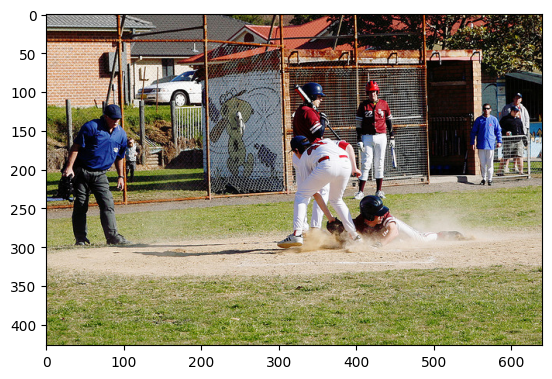

In [ ]:
print(gen_caption(1,test_unique_image['image'].iloc[4]))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


['cầu', 'thủ', 'bóng', 'chày', 'đang', 'cầm', 'gậy', 'thi', 'đấu', 'trên', 'sân', '<end>']


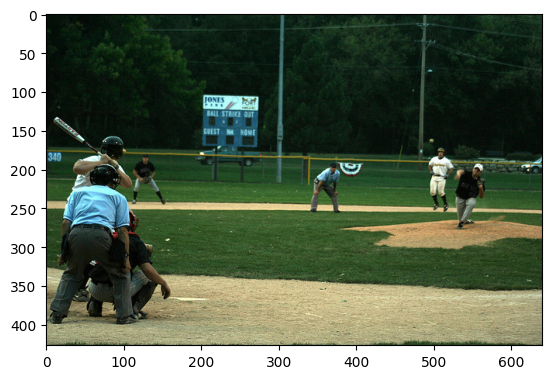

In [50]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))

['vận', 'động', 'viên', 'tennis', 'nam', 'đang', 'cầm', 'vợt', 'thi', 'đấu', 'trên', 'sân', '<end>']


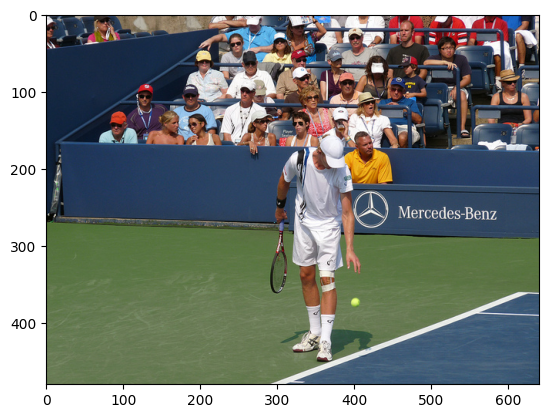

In [51]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))

['một', 'người', 'đàn', 'ông', 'đang', 'chuẩn', 'bị', 'phát', 'bóng', 'trên', 'sân', 'tennis', '<end>']


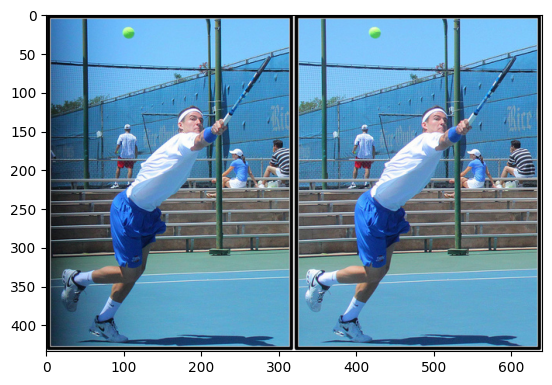

In [52]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))

['cầu', 'thủ', 'bóng', 'chày', 'đang', 'cầm', 'gậy', 'thi', 'đấu', 'trên', 'sân', '<end>']


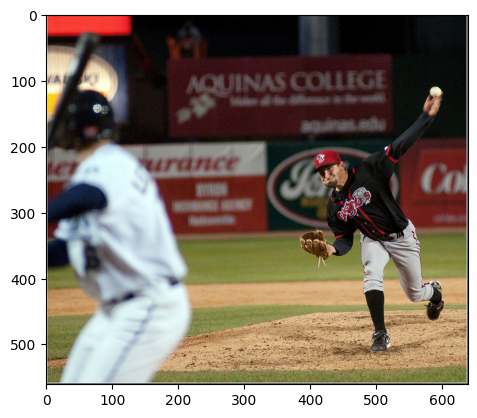

In [ ]:
print(gen_caption(1,test_unique_image['image'].iloc[np.random.randint(0,100)]))

# Evaluation

In [ ]:
print(len(test_unique_image))

231


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    return bleu, rouge, cider
!pip install pycocoevalcap
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/231 [00:00<?, ?image/s]

{'testlen': 2543, 'reflen': 2588, 'guess': [2543, 2312, 2081, 1850], 'correct': [1788, 1067, 675, 458]}
ratio: 0.9826120556410423

 ********** BLEU-4 ********** 
 [0.690774087157385, 0.5596464526584046, 0.46386474072480355, 0.39472595112341363]

 ********** ROUGH ********** 
 0.5861993895499596

 ********** CIDER  ********** 
 1.0972790056374797


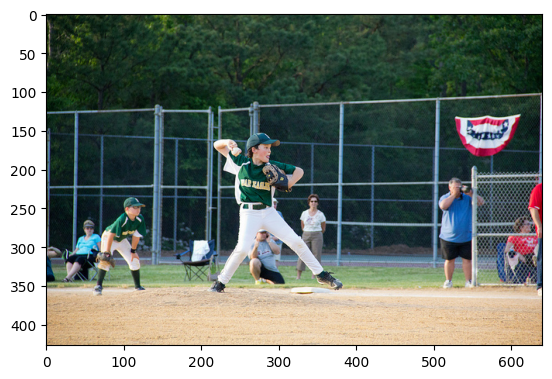

In [ ]:
# captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
#ref hypo
gts_dict , ref_dict = {} , {}
dem = 0
with tqdm(total=len(test_unique_image['image']) , unit = 'image') as pbar:
 for i, image_name in enumerate(test_unique_image['image']):
  # print(image_name)
  # image = valid_img_emb[image]
  # image_name = image_name[0]
  list_real_caption = [ ' '.join(i.split()[1:-2]) for i in img_path_to_caption_test[image_name]]
  # if len(list_real_caption) ==0:
  #   continue
  result = gen_caption(1, image_name)
  result = ' '.join(result[:-1])
  ref = [i.lower() for i in list_real_caption]
  test_sen = result#.split()
  # print('list_real_caption :',list_real_caption)
  # print(len(ref))
  if len(ref) == 0: 
    # print('list_real_caption: ', list_real_caption)
    # print('ref' , ref)
    # print('image_path_to_caption[image_name]: ',image_path_to_caption[image_name])
    dem +=1
  else:
    # print(len(test))
    # print('test :',test)
    # print('ref :',ref)
    # print(blue_score)
    gts_dict[image_name] = ref
    ref_dict[image_name] = [test_sen]

    # blue_score_list.append(blue_score)
    
  # pbar.set_description(f'i =  :  {i} || BLEU score ={np.sum(blue_score_list)/len(blue_score_list)}')
  pbar.update(1) 
  # break
b, r, c = score(gts_dict, ref_dict)
print('\n ********** BLEU-4 ********** \n', b)
print('\n ********** ROUGH ********** \n', r)
print('\n ********** CIDER  ********** \n', c)
torch.save(model_inference, './Bestmodel_{}'.format(c))
  # print(blue_score)

# Demo

In [ ]:
#Load model

model_inference = torch.load('/content/drive/MyDrive/Semester_5(2022-2023)/CS331_Thị giác máy tính nâng cao/FinalProject/Bestmodel')
start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

1 2 0


In [ ]:
list_temp = {'image':['/content/download.jpg', '/content/images.jpg']}
demo = pd.DataFrame(list_temp)
img_extract = extractFeatureEfficientNetV2(demo)
img_loader = DataLoader(img_extract, batch_size = 1, shuffle = False)

In [ ]:
for image_name, img in img_loader:
    print(image_name)
    print(img.shape)
    break

('/content/download.jpg',)
torch.Size([1, 3, 224, 224])


In [ ]:
img_emb_test1 = {name[0]:get_vector(img) for name, img in tqdm(img_loader)}

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
with open('valid_img_emb1.pkl', 'wb') as f:
  pickle.dump(img_emb_test1, f)

In [ ]:
valid_img_emb = pd.read_pickle('valid_img_emb1.pkl')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


['một', 'người', 'đàn', 'ông', 'đang', 'vung', 'gậy', 'để', 'đánh', 'quả', 'bóng', 'chày', '<end>']


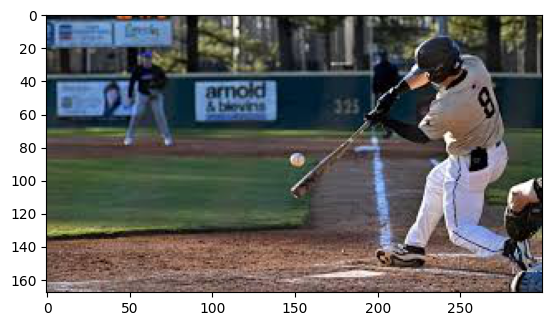

In [ ]:
print(gen_caption(1, demo['image'].iloc[1]))